In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 94% 291M/309M [00:03<00:00, 57.7MB/s]
100% 309M/309M [00:03<00:00, 91.2MB/s]


In [ ]:
!unzip /content/human-emotions-datasethes.zip

In [ ]:
TRAIN_PATH = "/content/Emotions Dataset/Emotions Dataset/train"
VAL_PATH = "/content/Emotions Dataset/Emotions Dataset/test"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , InputLayer , Conv2D , MaxPool2D , BatchNormalization ,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Recall ,Precision , TruePositives
from tensorflow.keras.metrics import TrueNegatives ,FalsePositives ,FalseNegatives ,CategoricalAccuracy

In [ ]:
CONFIG = {
    'CLASS_NAMES': ['angry','happy', 'sad'],
    'IMAGE_SIZE' : 256,
    'BATCH_SIZE' : 32 ,
    'MATREICS': [CategoricalAccuracy(name = 'Accuracy'),Precision(name = 'Precision') ,Recall(name = 'Recall'), TruePositives(name = 'TP') ,FalsePositives(name = 'FP'),TrueNegatives(name = 'TN') , FalseNegatives(name = 'FN')],
    'OPTIMIZER' : Adam(learning_rate =  1e-3),
    'LOSS' : CategoricalFocalCrossentropy(),
    'EPOCHS' : 20
}

In [ ]:
train_dataset = image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_dataset = image_dataset_from_directory(
    VAL_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

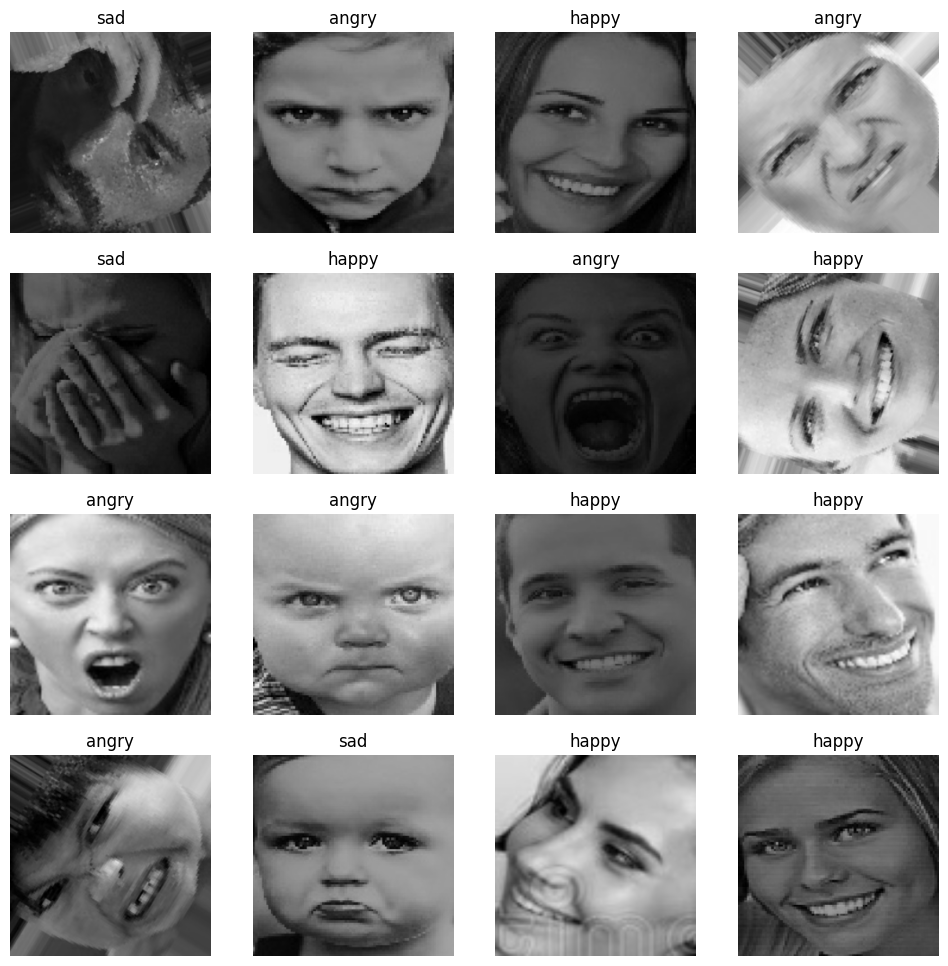

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIG["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
def augment_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    rotation_angle = tf.random.uniform(shape=[], minval=-50, maxval=50)
    image = tf.image.rot90(image, k=tf.cast(rotation_angle / 90, tf.int32))

    image = tf.image.random_flip_left_right(image)

    return image ,label

In [ ]:
train_dataset = train_dataset.map(augment_image)

In [ ]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

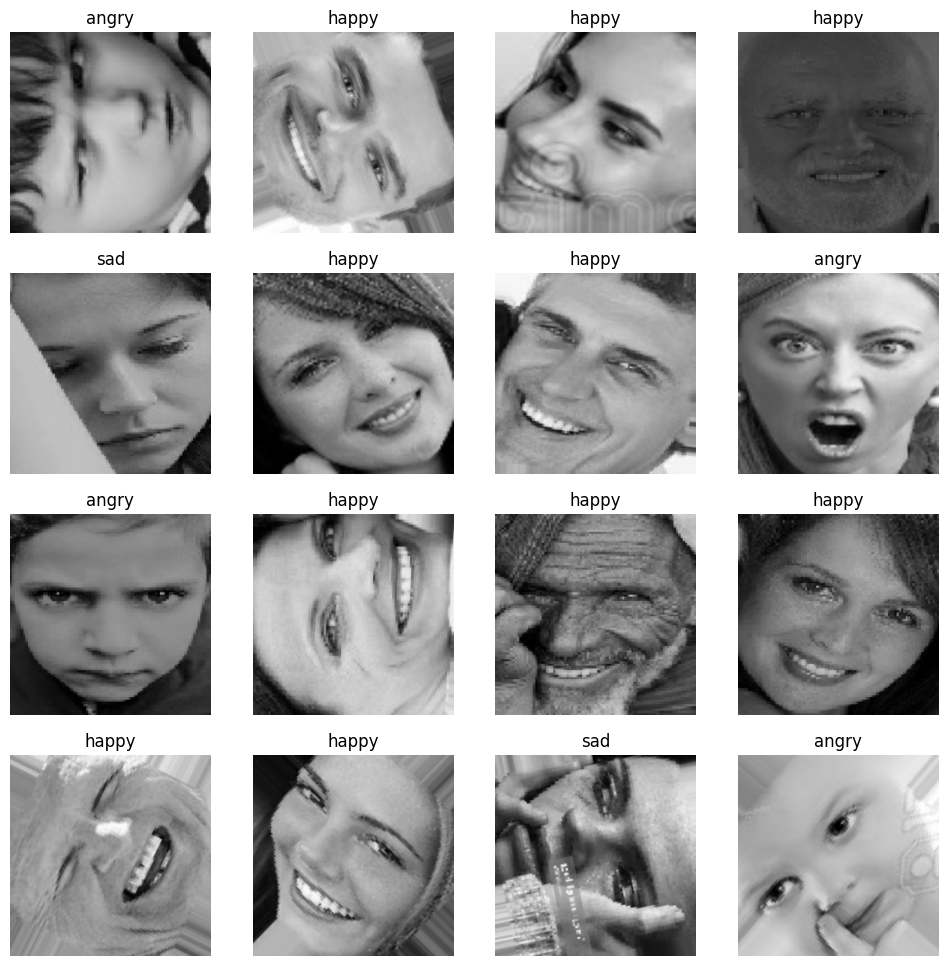

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIG["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = Sequential([

    InputLayer(input_shape = (CONFIG['IMAGE_SIZE'] ,CONFIG['IMAGE_SIZE'], 3), ),
    Conv2D(filters = 6, kernel_size = 3, strides = 1 , padding='valid',  activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),


    Flatten(),

    Dense( 1024, activation = "relu"),
    BatchNormalization(),


    Dense( 256 , activation = "relu"),
    BatchNormalization(),

    Dense(3, activation = "softmax"),

])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
model.compile(
    optimizer = CONFIG['OPTIMIZER'],
    metrics = CONFIG['MATREICS'],
    loss = CONFIG['LOSS']
)

In [ ]:
history = model.fit(train_dataset , validation_data=val_dataset , epochs= CONFIG['EPOCHS'], verbose = 1)

Epoch 1/20
213/213 [==============================] - 32s 98ms/step - loss: 0.1265 - Accuracy: 0.5251 - Precision: 0.6036 - Recall: 0.2867 - TP: 1949.0000 - FP: 1280.0000 - TN: 12318.0000 - FN: 4850.0000 - val_loss: 0.1144 - val_Accuracy: 0.5382 - val_Precision: 0.6136 - val_Recall: 0.3332 - val_TP: 759.0000 - val_FP: 478.0000 - val_TN: 4078.0000 - val_FN: 1519.0000
Epoch 2/20
213/213 [==============================] - 20s 88ms/step - loss: 0.0862 - Accuracy: 0.6449 - Precision: 0.7641 - Recall: 0.4430 - TP: 3012.0000 - FP: 930.0000 - TN: 12668.0000 - FN: 3787.0000 - val_loss: 0.1288 - val_Accuracy: 0.5105 - val_Precision: 0.6092 - val_Recall: 0.3503 - val_TP: 798.0000 - val_FP: 512.0000 - val_TN: 4044.0000 - val_FN: 1480.0000
Epoch 3/20
213/213 [==============================] - 20s 91ms/step - loss: 0.0708 - Accuracy: 0.7139 - Precision: 0.8152 - Recall: 0.5679 - TP: 3861.0000 - FP: 875.0000 - TN: 12723.0000 - FN: 2938.0000 - val_loss: 0.1210 - val_Accuracy: 0.5737 - val_Precision: 0

In [ ]:
model.evaluate(val_dataset)


72/72 [==============================] - 3s 34ms/step - loss: 0.2089 - Accuracy: 0.5356 - Precision: 0.5550 - Recall: 0.5136 - TP: 1170.0000 - FP: 938.0000 - TN: 3618.0000 - FN: 1108.0000


[0.20891189575195312,
 0.5355575084686279,
 0.5550284385681152,
 0.513608455657959,
 1170.0,
 938.0,
 3618.0,
 1108.0]

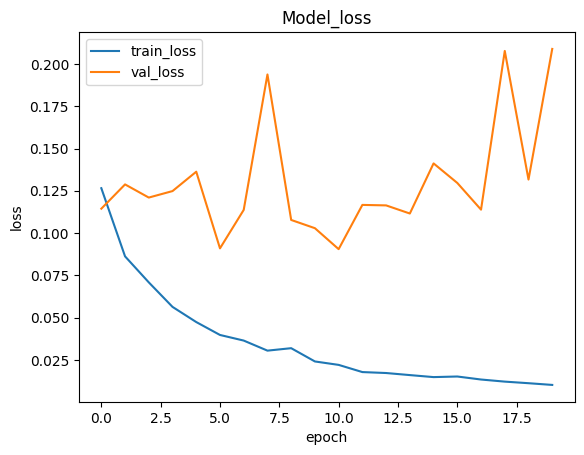

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

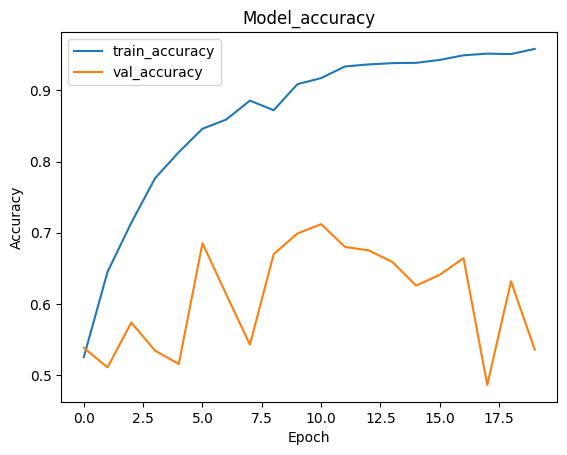

In [ ]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

1/1 [==============================] - 0s 31ms/step


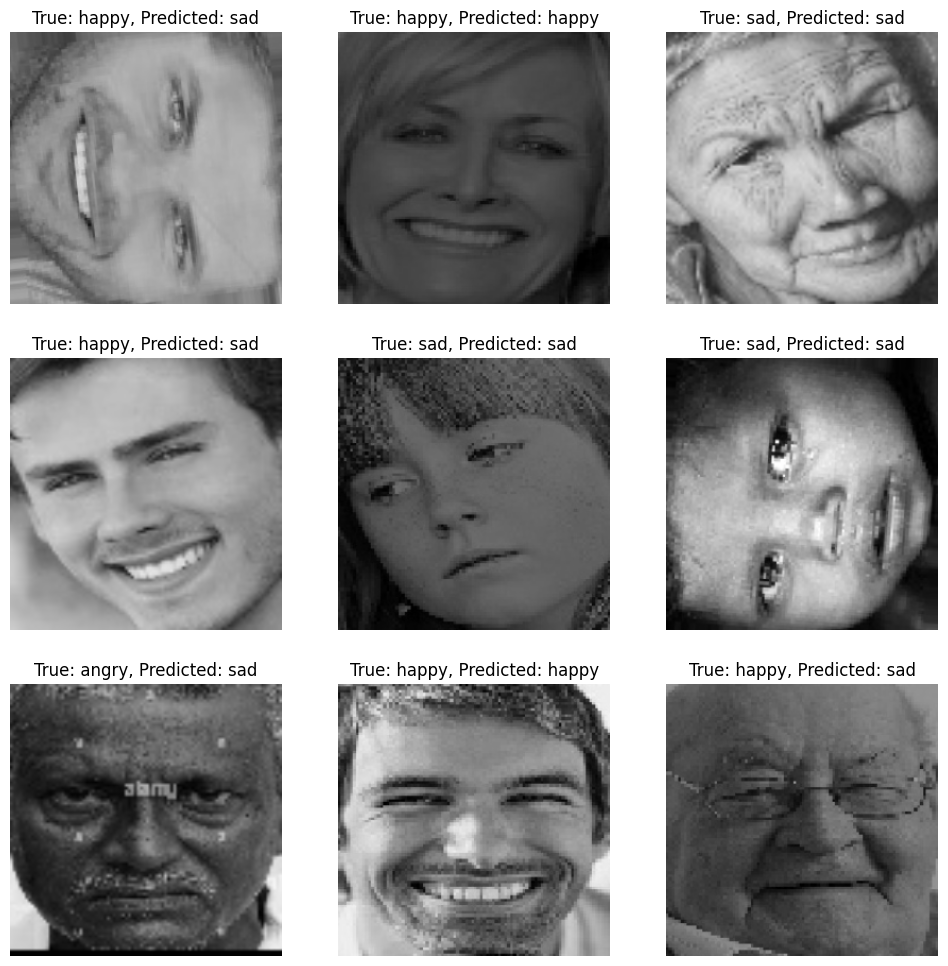

In [ ]:
plt.figure(figsize = (12,12))
for i, (image, label) in enumerate(val_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0]/255)
    predicted_label = tf.argmax(model.predict(image), axis=1).numpy()[0]
    true_label = tf.argmax(label, axis=1).numpy()[0]
    plt.title(f"True: {CONFIG['CLASS_NAMES'][true_label]}, Predicted: {CONFIG['CLASS_NAMES'][predicted_label]}")
    plt.axis('off')
plt.show()


In [ ]:
labels = []
pred = []

for image , label in val_dataset:
   labels.append(tf.argmax(label, axis=1).numpy()[0])
   pred.append(tf.argmax(model.predict(image), axis=1).numpy()[0])


In [ ]:
labels = np.array(labels)
pred = np.array(pred)

In [ ]:
labels.shape

(72,)

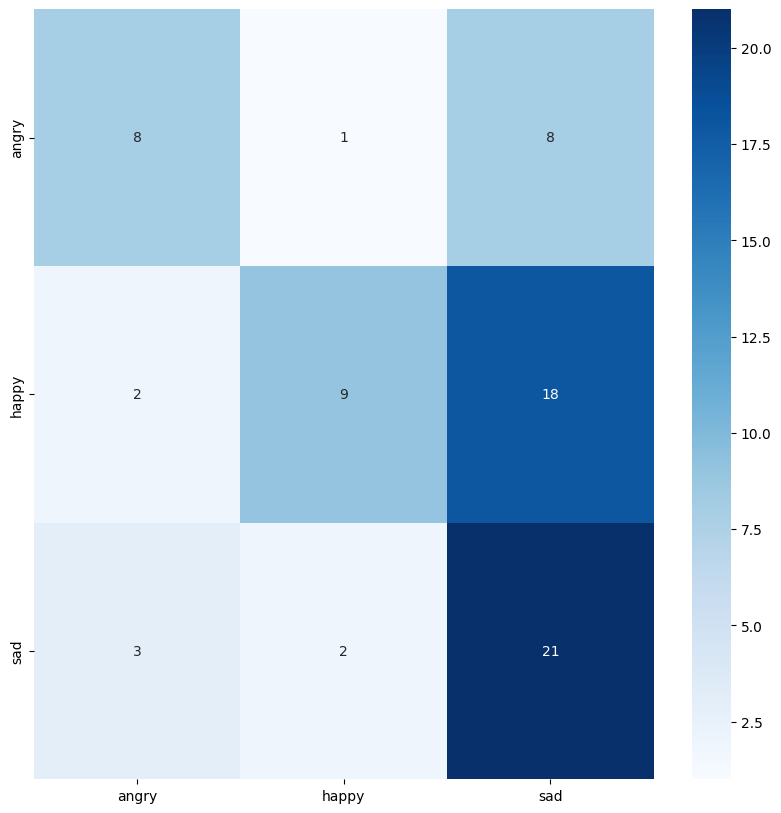

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels , pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm , annot = True , cmap = 'Blues' , xticklabels=CONFIG['CLASS_NAMES'] , yticklabels = CONFIG['CLASS_NAMES'])
plt.show()